In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

#Julia 
from julia.api import Julia
jl = Julia(compiled_modules=False)
from interpretableai import iai

import seaborn as sns

import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

## Load datasets

In [2]:
# Load anagraphics
anagraphics = pd.read_csv("../data/cremona/anagraphics/anagraphics.csv").dropna(how='all')

# Load drugs
drugs_cremona = pd.read_csv("../data/cremona/therapies/drugs_cremona.csv")
drugs_orgoglio_po = pd.read_csv("../data/cremona/therapies/drugs_oglio_po.csv")
drugs = drugs_cremona.append(drugs_orgoglio_po).dropna(how='all')

# Load comorbidities
comorbidities_data = pd.read_csv('../data/cremona/therapies/active_substances_comorbidities.csv')[['Active_substance', 'therapy_for_filtered']]

# Load vital signs in ER
er_vital_signs = pd.read_csv('../data/cremona/emergency_room/vital_signs.csv')
er_vital_signs['SCHEDA_PS'] = er_vital_signs['SCHEDA_PS'].astype(str)

In [3]:
# Select only covid patient
anagraphics = anagraphics[anagraphics['ESITO TAMPONE'].str.contains('POSITIVO')]

## Filter datasets

### Pick only people who have recovered or died

In [4]:
anagraphics = anagraphics[anagraphics["DATA DI DIMISSIONE/DECESSO"].notnull()]  # Pick only people with end date
anagraphics = anagraphics[~anagraphics['ESITO'].str.contains('TRASFERITO')] # Remove patients who have been transferred

def fix_outcome(outcome):
    if 'DIMESSO' in outcome:
        return 'DIMESSO'
    elif outcome == 'DECEDUTO':
        return outcome
    else:
        raise ValueError('Not recognized')
        
anagraphics['ESITO'] = anagraphics['ESITO'].apply(fix_outcome)  # Make outcome binary

### Filter common patients and drop duplicates

In [5]:
# Drop duplicates
n_orig = len(anagraphics)
anagraphics.drop_duplicates(['CODICE FISCALE', "ESITO"], inplace=True)
n_unique = len(anagraphics)
print("Removed %d duplicates with same (ID, outcome)" % (n_orig - n_unique))

# Drop patients with multiple diagnosis
n_orig = len(anagraphics)
anagraphics.drop_duplicates(['CODICE FISCALE'], inplace=True)
n_unique = len(anagraphics)
print("Removed %d duplicates with same (ID)" % (n_orig - n_unique))

# Drop patients with multiple diagnosis
n_orig = len(anagraphics)
anagraphics.drop_duplicates(['NOSOLOGICO'], inplace=True)
n_unique = len(anagraphics)
print("Removed %d duplicates with same (Nosologico)" % (n_orig - n_unique))

Removed 8 duplicates with same (ID, outcome)
Removed 2 duplicates with same (ID)
Removed 2 duplicates with same (Nosologico)


### Filter patients present in all datasets

In [6]:
# Filter by Codice Fiscale
patients_codice_fiscale = anagraphics[anagraphics["CODICE FISCALE"].isin(drugs["Codice Fiscale"])]['CODICE FISCALE'].unique()
drugs_covid = drugs[drugs['Codice Fiscale'].isin(patients_codice_fiscale)]
anagraphics = anagraphics[anagraphics['CODICE FISCALE'].isin(patients_codice_fiscale)]

# Filter by Nosologico
patients_nosologico = er_vital_signs[er_vital_signs['SCHEDA_PS'].isin(anagraphics["NOSOLOGICO"])]['SCHEDA_PS'].unique()
anagraphics = anagraphics[anagraphics['NOSOLOGICO'].isin(patients_nosologico)]
er_vital_signs = er_vital_signs[er_vital_signs['SCHEDA_PS'].isin(patients_nosologico)]

# Filter again Codice Fiscale
patients_codice_fiscale = anagraphics['CODICE FISCALE'].unique()
drugs_covid = drugs[drugs['Codice Fiscale'].isin(patients_codice_fiscale)]

print("Len patients by CF :", len(patients_codice_fiscale))
print("Len patients by Nosologico :", len(patients_nosologico))

Len patients by CF : 620
Len patients by Nosologico : 620


In [7]:
# Add Codice Fiscale to ER data
er_vital_signs['CODICE FISCALE'] = ""
for p in patients_codice_fiscale:
    nosologico = anagraphics[anagraphics['CODICE FISCALE'] == p]['NOSOLOGICO'].values
    if len(nosologico) > 1:
        raise ValueError("Duplicates in nosologico")
    er_vital_signs.loc[er_vital_signs['SCHEDA_PS'] == nosologico[0], 'CODICE FISCALE'] = p

### Fix swapped dates

In [8]:
idx_wrong = pd.to_datetime(anagraphics["DATA DI DIMISSIONE/DECESSO"], format='%m/%d/%y') < pd.to_datetime(anagraphics["DATA DI RICOVERO"], format='%m/%d/%y')
wrong_dates = anagraphics[['DATA DI DIMISSIONE/DECESSO','DATA DI RICOVERO']].loc[idx_wrong]
anagraphics.loc[idx_wrong, 'DATA DI RICOVERO'] = wrong_dates['DATA DI DIMISSIONE/DECESSO']
anagraphics.loc[idx_wrong, 'DATA DI DIMISSIONE/DECESSO'] = wrong_dates['DATA DI RICOVERO']

### Compute length of stay

In [9]:
def n_days(t):    
    if isinstance(t, str):
        date = datetime.datetime.strptime(t, '%m/%d/%y')
        new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
        day_of_the_year = (date - new_year_day).days + 1
        return day_of_the_year
    else:
        return np.NaN
anagraphics['length_of_stay'] = anagraphics["DATA DI DIMISSIONE/DECESSO"].apply(n_days) - anagraphics["DATA DI RICOVERO"].apply(n_days)
print("Minimum length of stay ", anagraphics['length_of_stay'].min())
print("Maximum length of stay ", anagraphics['length_of_stay'].max())

Minimum length of stay  0
Maximum length of stay  36


# Create final dataset

In [10]:
# Anagraphics (translated to english)
anagraphics_features = ['SESSO', "ETA'", 'ESITO']
dataset_anagraphics = pd.DataFrame(columns=anagraphics_features, index=patients_codice_fiscale)
dataset_anagraphics.loc[:, anagraphics_features] = anagraphics[['CODICE FISCALE'] + anagraphics_features].set_index('CODICE FISCALE')
dataset_anagraphics = dataset_anagraphics.rename(columns={"ETA'": "age", "SESSO": "sex", "ESITO": "outcome"})
dataset_anagraphics.loc[:, 'sex'] = dataset_anagraphics.loc[:, 'sex'].astype('category')
dataset_anagraphics.loc[:, 'outcome'] = dataset_anagraphics.loc[:, 'outcome'].astype('category')
dataset_anagraphics['outcome'] = dataset_anagraphics['outcome'].cat.rename_categories({'DIMESSO': 'discharged', 'DECEDUTO': 'deceased'})
dataset_anagraphics

,sex,age,outcome
BDLBSD81E15Z336M,M,38,discharged
CBNNGL56T64Z129F,F,63,discharged
GSTDNT33C25L426A,M,87,deceased
LSSNGL46S02B715H,M,73,deceased
LMNPLN86R67Z129Q,F,33,discharged
...,...,...,...
ZLTLRT72B29H509N,M,48,discharged
ZPPRFR54E25I561A,M,66,discharged
ZPPVNI52C13D150X,M,68,discharged
ZCCFNC36E23D150T,M,83,deceased


In [11]:
# Comorbidities from drugs
comorbidities = comorbidities_data['therapy_for_filtered'].dropna().unique().tolist()
dataset_comorbidities = pd.DataFrame(0, columns=comorbidities, index=patients_codice_fiscale)
for p in patients_codice_fiscale:
    drugs_p = drugs_covid[drugs_covid['Codice Fiscale'] == p]['Principio Attivo']
    for d in drugs_p:
        if d != 'NESSUN PRINCIPIO ATTIVO':
            comorb_d = comorbidities_data[comorbidities_data['Active_substance'] == d]['therapy_for_filtered']
            if len(comorb_d) != 1: 
                import ipdb; ipdb.set_trace()
                raise ValueError('Error in dataset. We need only one entry per active substance')
            comorb_d = comorb_d.iloc[0]
            if not pd.isnull(comorb_d):
                dataset_comorbidities.loc[p, comorb_d] = 1
                
# Drop columns with all zeroes
for c in comorbidities:
    if dataset_comorbidities[c].sum() == 0:
        dataset_comorbidities.drop(c, axis='columns', inplace=True)
dataset_comorbidities = dataset_comorbidities.astype('category')

# Final
data_with_comorbidities = dataset_anagraphics.join(dataset_comorbidities)

In [12]:
# Data with ER vitals
vital_signs = ['SaO2', 'P. Max', 'P. Min', 'F. Card.', 'F. Resp.', 'Temp.', 'Dolore', 'GCS', 'STICKGLI']
dataset_vitals = pd.DataFrame(np.nan, columns=vital_signs, index=patients_codice_fiscale)
for p in patients_codice_fiscale:
    vitals_p = er_vital_signs[er_vital_signs['CODICE FISCALE'] == p][['NOME_PARAMETRO_VITALE', 'VALORE_PARAMETRO']]
    for vital_name in vital_signs:
        # Take mean if multiple values
        vital_value = vitals_p[vitals_p['NOME_PARAMETRO_VITALE'] == vital_name]['VALORE_PARAMETRO']
        vital_value = pd.to_numeric(vital_value).mean()
        dataset_vitals.loc[p, vital_name] = vital_value

# Drop columns with less than 30% values
nan_threashold = 35
percent_missing = dataset_vitals.isnull().sum() * 100 / len(dataset_vitals)
missing_value_dataset_vitals = pd.DataFrame({'percent_missing': percent_missing})
vital_signs = missing_value_dataset_vitals[missing_value_dataset_vitals['percent_missing'] < nan_threashold].index.tolist()               
dataset_vitals = dataset_vitals[vital_signs]

# Input missing values
imputed_dataset_vitals = iai.impute(dataset_vitals)
imputed_dataset_vitals.index = dataset_vitals.index

# Rename to English
imputed_dataset_vitals = imputed_dataset_vitals.rename(columns={"P_ Max": "systolic_blood_pressure", 
                                                                "P_ Min": "diastolic_blood_pressure", 
                                                                "F_ Card_": "cardiac_frequency",
                                                                "Temp_": "temperature_celsius",
                                                                "F_ Resp_": "respiratory_frequency"})


# Final
data_with_comorbidities_and_signs = data_with_comorbidities.join(imputed_dataset_vitals)

In [13]:
data_ml = data_with_comorbidities_and_signs
data_ml

,sex,age,outcome,diabetes,hypertension,chronic_heart_condition,anaemia,osteoporosis,acidosis,asthma,...,chronic_liver,chronic_kidney,rickets,leukemia,SaO2,systolic_blood_pressure,diastolic_blood_pressure,cardiac_frequency,respiratory_frequency,temperature_celsius
BDLBSD81E15Z336M,M,38,discharged,0,0,0,0,0,0,0,...,0,0,0,0,97.0,120.000000,80.000000,89.684225,16.857719,38.700000
CBNNGL56T64Z129F,F,63,discharged,0,0,0,0,0,0,0,...,0,0,0,0,97.5,125.000000,60.000000,64.000000,16.000000,36.550000
GSTDNT33C25L426A,M,87,deceased,0,0,1,0,0,0,0,...,0,0,0,0,79.6,107.666667,65.000000,94.333333,30.000000,36.000000
LSSNGL46S02B715H,M,73,deceased,1,1,0,0,0,0,1,...,0,0,0,0,86.5,170.000000,85.000000,88.500000,30.000000,36.625000
LMNPLN86R67Z129Q,F,33,discharged,0,0,0,0,0,0,0,...,0,0,0,0,98.0,100.000000,60.000000,102.000000,24.000000,37.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZLTLRT72B29H509N,M,48,discharged,0,0,0,0,0,0,0,...,0,0,0,0,98.0,133.442252,79.895033,105.000000,18.000000,38.200000
ZPPRFR54E25I561A,M,66,discharged,0,0,0,0,0,0,0,...,0,0,0,0,99.0,122.924539,69.956266,79.127602,17.161963,37.100000
ZPPVNI52C13D150X,M,68,discharged,0,1,1,0,0,0,0,...,0,0,0,0,92.0,132.238871,80.488047,90.000000,17.426564,38.300203
ZCCFNC36E23D150T,M,83,deceased,0,0,1,0,0,0,0,...,0,0,0,0,94.0,133.500000,75.000000,15.000000,15.000000,37.277500


## Train trees

In [ ]:
SEED = 1
X = data_ml.loc[:, data_ml.columns != 'outcome']
y = data_ml.loc[:, 'outcome']
(X_train, y_train), (X_test, y_test) = iai.split_data('classification', X, y, train_proportion=0.8, seed = SEED)

In [ ]:
grid = iai.GridSearch(
    iai.OptimalTreeClassifier(
        random_seed = SEED,
    ),
    max_depth=range(1, 10),
    minbucket=[5, 10, 15, 20, 25, 30, 35],
    ls_num_tree_restarts=200,
)
grid.fit_cv(X_train, y_train, n_folds=10, validation_criterion = 'auc')

In [ ]:
print('In Sample Misclassification', grid.score(X_train, y_train, criterion='misclassification'))
print('Out of Sample Misclassification', grid.score(X_test, y_test, criterion='misclassification'))

print('In Sample AUC', grid.score(X_train, y_train, criterion='auc'))
print('Out of Sample AUC', grid.score(X_test, y_test, criterion='auc'))

In [ ]:
grid.get_best_params()

In [ ]:
grid.get_learner()

## Save trees 

In [21]:
best_learner = grid.get_learner()
best_learner.write_json('trees/cv10_seed1234567/learner.json')
best_learner.write_questionnaire('trees/cv10_seed1234567/app.html')

1460559

## Correlation matrix

In [14]:
data_corr = data_ml.copy()
data_corr['sex'] = data_corr['sex'].astype(object)
data_corr.loc[data_corr['sex'] == 'M','sex'] = 0
data_corr.loc[data_corr['sex'] == 'F','sex'] = 1
X_corr = data_corr.loc[:, data_corr.columns != 'outcome'].astype(np.float64)
X_corr.corr()

,sex,age,diabetes,hypertension,chronic_heart_condition,anaemia,osteoporosis,acidosis,asthma,hypercholesterolemia,...,chronic_liver,chronic_kidney,rickets,leukemia,SaO2,systolic_blood_pressure,diastolic_blood_pressure,cardiac_frequency,respiratory_frequency,temperature_celsius
sex,1.000000,-0.036757,-0.106315,-0.079179,0.003694,0.042777,-0.038075,-0.031094,0.042614,-0.020322,...,-0.019425,0.052886,-0.052995,0.052886,0.029121,0.043392,-0.042647,0.076330,-0.011525,-0.039927
age,-0.036757,1.000000,0.164542,0.359022,0.218187,0.041380,0.094127,0.020515,0.051042,0.095751,...,0.039016,0.009145,-0.058904,0.042156,-0.260061,0.041946,-0.158022,-0.204841,0.140779,-0.150430
diabetes,-0.106315,0.164542,1.000000,0.199765,0.173374,0.012295,0.087093,-0.002494,0.143870,0.159720,...,0.007641,-0.020803,0.020846,-0.020803,-0.116564,-0.005353,-0.074768,-0.043910,0.100973,-0.057112
hypertension,-0.079179,0.359022,0.199765,1.000000,0.244083,0.102143,0.100896,0.075365,0.122515,0.188471,...,0.026413,-0.048087,0.058283,-0.048087,-0.077437,0.081415,0.008295,-0.133715,0.036958,-0.093303
chronic_heart_condition,0.003694,0.218187,0.173374,0.244083,1.000000,0.086455,0.161833,-0.014397,0.137281,0.146024,...,-0.003802,-0.024504,0.114375,0.065928,-0.051962,0.085271,-0.037117,-0.121238,-0.036666,0.014014
anaemia,0.042777,0.041380,0.012295,0.102143,0.086455,1.000000,0.193297,-0.016883,0.120325,-0.008652,...,0.096277,0.214664,-0.013056,-0.007526,0.007231,-0.017428,-0.025701,-0.035081,-0.018632,0.007917
osteoporosis,-0.038075,0.094127,0.087093,0.100896,0.161833,0.193297,1.000000,0.026701,0.059992,0.044084,...,-0.028049,0.115473,0.050595,-0.013990,-0.095649,-0.031450,-0.084007,-0.022919,-0.021989,-0.009764
acidosis,-0.031094,0.020515,-0.002494,0.075365,-0.014397,-0.016883,0.026701,1.000000,0.021285,0.026062,...,-0.007266,-0.003624,-0.006287,-0.003624,0.044134,-0.008060,0.012308,-0.020777,-0.039602,-0.027965
asthma,0.042614,0.051042,0.143870,0.122515,0.137281,0.120325,0.059992,0.021285,1.000000,-0.005280,...,-0.030119,-0.015023,-0.026063,-0.015023,-0.076551,-0.019171,-0.063449,-0.028127,0.003652,0.004540
hypercholesterolemia,-0.020322,0.095751,0.159720,0.188471,0.146024,-0.008652,0.044084,0.026062,-0.005280,1.000000,...,-0.028283,-0.014107,-0.024474,-0.014107,0.029020,-0.003669,-0.026394,-0.100001,-0.069251,-0.080898


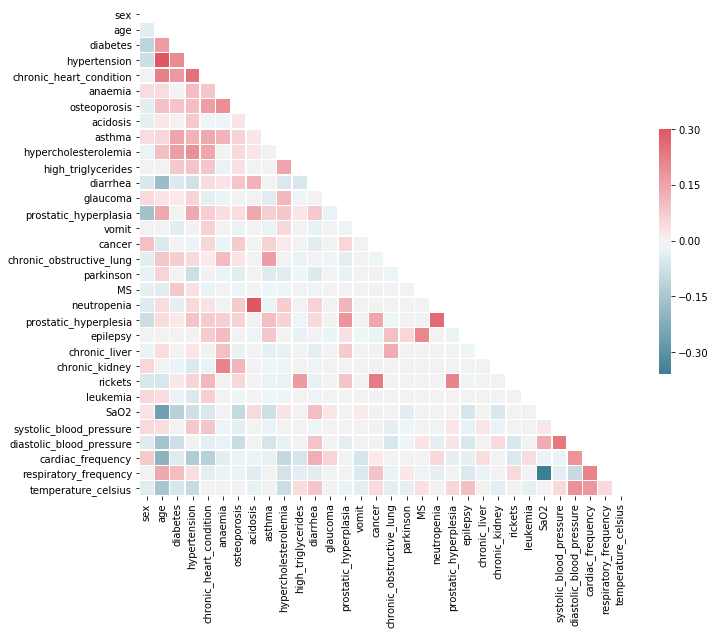

In [15]:
mask = np.triu(np.ones_like(X_corr.corr(), dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(X_corr.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [16]:
X_corr.corr().iloc[1,3]

0.359021763458014

In [17]:
upper = X_corr.corr().where(np.triu(np.ones(X_corr.corr().shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.25
rows, columns = np.where(abs(upper) > 0.25)

In [18]:
list(zip(upper.columns[rows], upper.columns[columns]))

[('age', 'hypertension'),
 ('age', 'SaO2'),
 ('acidosis', 'neutropenia'),
 ('neutropenia', 'prostatic_hyperplesia'),
 ('SaO2', 'respiratory_frequency')]

## Try Gradient Boosting, RF and  XGBoost

In [19]:
SEED = 1
data_test = data_corr.copy()
data_test.outcome = data_test.outcome.astype(str)
data_test.loc[data_test['outcome'] == 'discharged','outcome'] = 0
data_test.loc[data_test['outcome'] == 'deceased','outcome'] = 1

X = data_test.loc[:, data_test.columns != 'outcome']
y = data_test.loc[:, 'outcome']

(X_train, y_train), (X_test, y_test) = iai.split_data('classification', X, y, train_proportion=0.8, seed = SEED)

In [20]:
#DEFINE FUNCTION THAT COMPUTES ACCURACY, TPR, FPR, AND AUC for GIVEN MODEL
def Scores(model, t_X, t_Y, te_X, te_Y):
    
    # misclassification accuracies
    accTrain = np.round(sum(model.predict(t_X) == t_Y)/len(t_Y),2)
    accTest = np.round(sum(model.predict(te_X) == te_Y)/len(te_Y),2)
    
    pred_t_Y = model.predict_proba(t_X)[:, 1]
    pred_te_Y = model.predict_proba(te_X)[:, 1]
    
    is_fpr, is_tpr, _ = roc_curve(t_Y, pred_t_Y)
    isAUC = auc(is_fpr, is_tpr)
    
    ofs_fpr, ofs_tpr, _ = roc_curve(te_Y, pred_te_Y)
    ofsAUC = auc(ofs_fpr, ofs_tpr)
    
    return (accTrain, accTest, ofs_fpr, ofs_tpr, isAUC, ofsAUC)

#DEFINE FUNCTION THAT RETURNS TOP 10 PREDICTORS GIVEN A MODEL 
def top10(model, trainX):
    try:
        varsImpo = pd.DataFrame({'names':trainX.columns, 'vals':model.feature_importances_})
        varsImpo = varsImpo.sort_values(by='vals', ascending = False)
    
    except:
        print("The model does not support the method: feature_importances_")
    
    return varsImpo.iloc[:10]

In [23]:
#INITIATE 10-FOLD CV
param_grid_gb = {
        "learning_rate": [0.001, 0.01, 0.1],
        "min_samples_leaf": [4, 8, 12, 20],
        "n_estimators": [3000, 2500, 2000, 1500]
}
GB = GradientBoostingClassifier()
gridsearch1 = GridSearchCV(estimator = GB, param_grid = param_grid_gb, cv = 10, verbose = 1)
gridsearch1.fit(X_train, y_train)

#RECORD BEST MODEL 
bestHyp = gridsearch1.best_params_
bestGB = gridsearch1.best_estimator_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 10.7min finished
/Users/lucamingardi/opt/anaconda3/envs/healthcare/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
accTrain_GB, accTest_GB, ofs_fpr_GB, ofs_tpr_GB, isAUC_GB, ofsAUC_GB  = Scores(bestGB, X_train, y_train, X_test, y_test)

In [25]:
bestHyp

{'learning_rate': 0.001, 'min_samples_leaf': 4, 'n_estimators': 1500}

In [26]:
accTrain_GB, ofsAUC_GB

(0.86, 0.915)

In [27]:
top10(bestGB, X_train)

,names,vals
1,age,0.624764
26,SaO2,0.219823
30,respiratory_frequency,0.054412
28,diastolic_blood_pressure,0.039287
3,hypertension,0.016321
31,temperature_celsius,0.013996
0,sex,0.012035
29,cardiac_frequency,0.006809
8,asthma,0.005696
9,hypercholesterolemia,0.002562


In [21]:
##### INITIATE 10-FOLD CV
param_grid_rf = {
        "bootstrap": [True],
        "max_features": ['sqrt', 'log2'],
        "min_samples_leaf": [4, 8, 12, 20],
        "min_samples_split": [3, 5, 8],
        "n_estimators": [400, 800, 1000, 2000]
}
RF = RandomForestClassifier()
gridsearch2 = GridSearchCV(estimator = RF, param_grid = param_grid_rf, cv = 10, verbose = 1)
gridsearch2.fit(X_train, y_train)

#RECORD BEST MODEL 
bestHypRF = gridsearch2.best_params_
bestRF = gridsearch2.best_estimator_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 20.3min finished
/Users/lucamingardi/opt/anaconda3/envs/healthcare/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [22]:
accTrain_RF, accTest_RF, ofs_fpr_RF, ofs_tpr_RF, isAUC_RF, ofsAUC_RF = Scores(bestRF, X_train, y_train, X_test, y_test)

In [23]:
bestHypRF

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 400}

In [28]:
accTest_RF, ofsAUC_RF

(0.86, 0.9243243243243242)

In [30]:
top10(bestRF, X_train)

,names,vals
1,age,0.312180
26,SaO2,0.206495
30,respiratory_frequency,0.100503
28,diastolic_blood_pressure,0.083049
27,systolic_blood_pressure,0.059810
29,cardiac_frequency,0.053715
31,temperature_celsius,0.048954
3,hypertension,0.034751
4,chronic_heart_condition,0.029978
2,diabetes,0.015830


In [33]:
#INITIATE 10-FOLD CV
param_grid_xgb = {
        "learning_rate": [0.001, 0.01, 0.1],
        "min_samples_leaf": [4, 8, 12, 20],
        "n_estimators": [3000, 2500, 2000, 1500]
}
XGB = xgb.XGBClassifier()
gridsearch3 = GridSearchCV(estimator = XGB, param_grid = param_grid_xgb, cv = 10, verbose = 1)
gridsearch3.fit(X_train.astype(int), y_train, eval_metric="auc")

#RECORD BEST MODEL 
bestHyp_XGB = gridsearch3.best_params_
bestXGB = gridsearch3.best_estimator_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 10.5min finished
/Users/lucamingardi/opt/anaconda3/envs/healthcare/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
accTrain_XGB, accTest_XGB, ofs_fpr_XGB, ofs_tpr_XGB, isAUC_XGB, ofsAUC_XGB  = Scores(bestXGB, X_train.astype(int), y_train, X_test.astype(int), y_test)

In [35]:
accTest_XGB, ofsAUC_XGB

(0.84, 0.9204054054054054)

In [36]:
bestHyp_XGB

{'learning_rate': 0.001, 'min_samples_leaf': 4, 'n_estimators': 2500}

In [37]:
top10(bestXGB, X_train.astype(int))

,names,vals
1,age,0.296540
30,respiratory_frequency,0.119884
26,SaO2,0.106700
4,chronic_heart_condition,0.073756
31,temperature_celsius,0.067319
0,sex,0.059204
28,diastolic_blood_pressure,0.054050
6,osteoporosis,0.047298
29,cardiac_frequency,0.045934
3,hypertension,0.039287


## Anonymize, translate and store

In [ ]:
# data_with_comorbidities.reset_index(inplace=True, drop=True)
# data_with_comorbidities.to_csv('data.csv')

## Add ICU

In [129]:
icu = pd.read_excel("../../covid19_cremona_scan/Rosario Canino - TRASFERIMENTI.xlsx")
icu.NOSOLOGICO = icu.NOSOLOGICO.astype(str)
icu.drop_duplicates(['NOSOLOGICO'], inplace=True)

In [130]:
# Match CODICE FISCALE with NOSOLOGICO and store in new dataset
data_icu = anagraphics[anagraphics['CODICE FISCALE'].isin(data_ml.index)][["CODICE FISCALE", "NOSOLOGICO"]].join(data_ml, on = "CODICE FISCALE")

# Merge data to get transfer to ICU
data_icu = data_icu.merge(icu[['NOSOLOGICO', 'DESCR_REP_DA', 'DESCR_REP_A']], 
               how = 'left', left_on = "NOSOLOGICO", right_on = "NOSOLOGICO")

In [162]:
len(data_icu[data_icu.DESCR_REP_A == 'TERAPIA INTENSIVA CR'])+len(data_icu[data_icu.DESCR_REP_A == 'TERAPIA INTENSIVA OP'])

41

In [36]:
import pickle

In [37]:
with open('/Users/lucamingardi/Dropbox (MIT)/covid19_calculator/calculator/predictors/outcome/RF/cv10_script_seed1_icu/model.pkl', 'rb') as f:
    rf = pickle.load(f)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=2500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [42]:
data_ml.dtypes

sex                         category
age                           object
outcome                     category
diabetes                    category
hypertension                category
chronic_heart_condition     category
anaemia                     category
osteoporosis                category
acidosis                    category
asthma                      category
hypercholesterolemia        category
high_triglycerides          category
diarrhea                    category
glaucoma                    category
prostatic_hyperplasia       category
vomit                       category
cancer                      category
chronic_obstructive_lung    category
parkinson                   category
MS                          category
neutropenia                 category
prostatic_hyperplesia       category
epilepsy                    category
chronic_liver               category
chronic_kidney              category
rickets                     category
leukemia                    category
S